In [197]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [198]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
NUM_WORDS = 1000
EMBEDDING_DIM = 100
MAXLEN = 200
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAIN_FILE = "processed_train.csv"
TEST_FILE = "processed_test.csv"
STOPWORDS_FILE = "stopwordbahasa.csv"
STOPWORDS = []
num_classes = 4
learning_rate = 0.001
batch_size = 16
num_epochs = 10

In [200]:
def load_stopwords(stopwords_file=STOPWORDS_FILE):
    """
    Loads the stopwords from the stopwords file
    
    Args:
        stopwords_file (string): path to the stopwords file
    Returns:
        stopwords (list): list of stopwords
    """
    with open('/content/drive/MyDrive/Colab Notebooks/stopwordbahasa.csv', 'r') as f:
        stopwords = []
        reader = csv.reader(f)
        for row in reader:
            stopwords.append(row[0])
        
        return stopwords

STOPWORDS = load_stopwords(STOPWORDS_FILE)

In [201]:
STOPWORDS[:5]

['ada', 'adalah', 'adanya', 'adapun', 'agak']

In [202]:
def remove_stopwords(sentence, stopwords=STOPWORDS):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
        stopwords (list): list of stopwords to remove from the sentence
        
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    sentence = sentence.lower()
    words = sentence.split()
    no_stopwords = [word for word in words if word not in stopwords]
    sentence = " ".join(no_stopwords)
    return sentence

In [203]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    
    Args:
        filename (string): path to the CSV file
    
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r', encoding="utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            toxicity = int(row[2]) + int(row[3]) + int(row[4]) + int(row[5])
            if toxicity > 0:
                labels.append(1)
            else:
                labels.append(0)
            sentence = row[6]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, np.array(labels)

In [204]:
test_sentences, test_labels = parse_data_from_file("/content/drive/MyDrive/Colab Notebooks/processed_test.csv")
train_sentences, train_labels  = parse_data_from_file("/content/drive/MyDrive/Colab Notebooks/processed_train.csv")

In [205]:
print(train_sentences[0])
print(train_labels[0])

print(test_sentences[0])
print(test_labels[0])

# number of sentences in the training set
print(f"No. of sentences in the training set: {len(train_sentences)}")

# number of sentences in the test set
print(f"No. of sentences in the test set: {len(test_sentences)}")

# shape of the labels in the training set
print(f"Shape of the labels in the training set: {train_labels.shape}")

# shape of the labels in the test set
print(f"Shape of the labels in the test set: {test_labels.shape}")

jabar provinsi barokah nwoi anjing bodoh npropinsi ngerusak ngebakar gereja jatim provinsi lumbung nasbung jatim npropinsi penghasil gembong teroris jateng lumbung nasbung jateng ngarang stereotip piliah pilih nbangsat pecun
1
spanduk prof video orasi buku lainlain sngat heran rkyat tolol jls niat hizbut tahrir tegakan khilafah ganti negara kesatuan republik indonesia berkilah tegakan khilafah munafik apanya khilafah
1
No. of sentences in the training set: 6995
No. of sentences in the test set: 778
Shape of the labels in the training set: (6995,)
Shape of the labels in the test set: (778,)


In [206]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [207]:
# Test function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 28899 words

<OOV> token included in vocabulary


In [208]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """ 
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return padded_sequences

In [209]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {test_padded_seq.shape}")

Padded training sequences have shape: (6995, 200)

Padded validation sequences have shape: (778, 200)


In [219]:
def create_model(num_words, embedding_dim, maxlen):
    tf.random.set_seed(123)
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")  
    ])
    
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [220]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_labels, epochs=50, validation_data=(test_padded_seq, test_labels))

Epoch 1/50
219/219 [==============================] - 4s 12ms/step - loss: 0.9727 - accuracy: 0.5580 - precision_67: 0.5628 - recall_67: 0.9547 - val_loss: 0.7000 - val_accuracy: 0.5553 - val_precision_67: 0.5553 - val_recall_67: 1.0000
Epoch 2/50
219/219 [==============================] - 3s 14ms/step - loss: 0.6904 - accuracy: 0.5617 - precision_67: 0.5617 - recall_67: 1.0000 - val_loss: 0.6885 - val_accuracy: 0.5553 - val_precision_67: 0.5553 - val_recall_67: 1.0000
Epoch 3/50
219/219 [==============================] - 2s 9ms/step - loss: 0.6865 - accuracy: 0.5617 - precision_67: 0.5617 - recall_67: 1.0000 - val_loss: 0.6883 - val_accuracy: 0.5553 - val_precision_67: 0.5553 - val_recall_67: 1.0000
Epoch 4/50
219/219 [==============================] - 2s 8ms/step - loss: 0.6864 - accuracy: 0.5617 - precision_67: 0.5617 - recall_67: 1.0000 - val_loss: 0.6874 - val_accuracy: 0.5553 - val_precision_67: 0.5553 - val_recall_67: 1.0000
Epoch 5/50
219/219 [==============================] - 

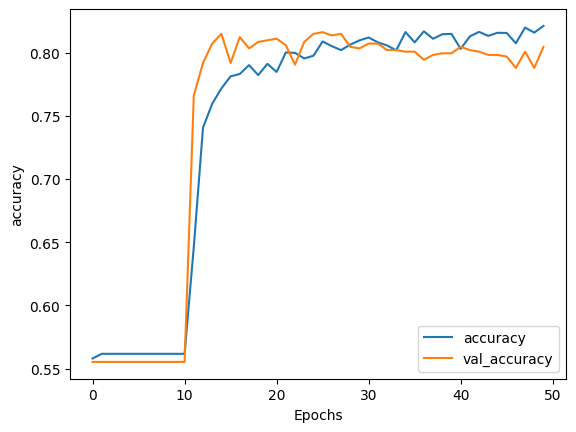

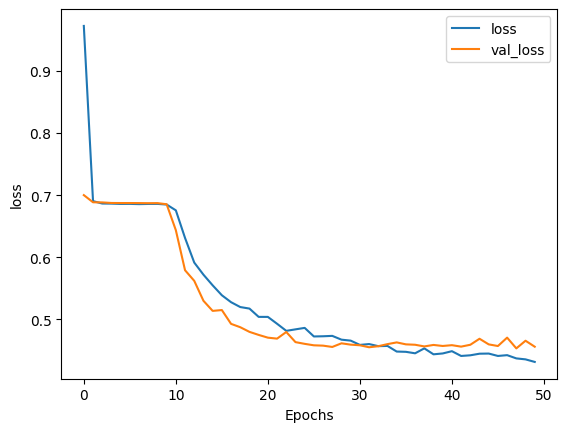

In [221]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")